# torch.autograd를 사용한 자동 미분
- URL from : https://tutorials.pytorch.kr/beginner/basics/autogradqs_tutorial.html#optional-reading-jacobian-product
- 신경망을 학습할 때 가장 자주 사용되는 알고리즘은 '역전파'다. 이 알고리즘에서, 매개변수(모델의 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도(gradient)에 따라 조정된다.
- 이러한 변화도를 계산하기 위해 pytorch에 내장되어있는 torch.autograd를 이용해서 모든 계산 그래프에 대해서 변화도 자동 계산을 할 수 있다.

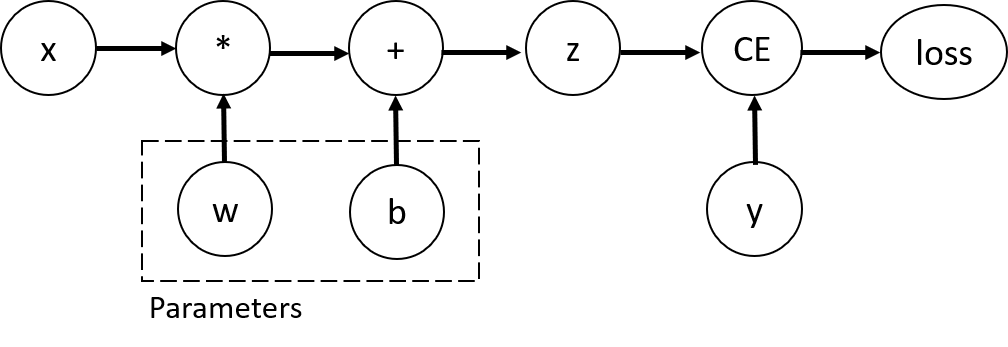

Tensor, Function and Computational graph
- 이 신경망에서, w와 b는 최적화를 해야 하는 매개변수다. 이런 변수들에 대한 손실 함수의 변화도를 계산해야 하고, 이를 위해 해당 텐서에 requires_grad 속성을 설정한다.
- requres_grad의 값은 텐서를 생성할 때 설정하거나, 추후 x.requires_grad_(True) 메소드를 사용해 설정할 수 있다.
- 연산 그래프를 구성하기 위헤 텐서에 적용하는 함수는 Function 클래스의 객체인데, 이 객체는 순전파 방향으로 함수를 계산하는 방법과 역방향 전파 단계에서 도함수(derivative)를 계산하는 방법도 알고 있다.
- 역방향 전파 함수에 대한 참조(reference)는 텐서의 grad_fn 속성에 저장된다.

In [1]:
"""입력 x, 매개변수 w, b, 일부 손실함수가 갖춰진 간단한 단일 계층 신경망"""
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [2]:
print(f"Gradient fuction for z = {z.grad_fn}")
print(f"Gradient fuction for loss = {loss.grad_fn}")

Gradient fuction for z = <AddBackward0 object at 0x7f57fc22a700>
Gradient fuction for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f57fc22ae50>


Calculate Gradient
- 신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수를 계산해야 한다.
- 이런 도함수를 계산하기 위해 loss.backward()를 호출한다.

In [3]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3038, 0.0019, 0.2190],
        [0.3038, 0.0019, 0.2190],
        [0.3038, 0.0019, 0.2190],
        [0.3038, 0.0019, 0.2190],
        [0.3038, 0.0019, 0.2190]])
tensor([0.3038, 0.0019, 0.2190])


변화도 추적 멈추기
- 모델을 학습한 뒤, 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는 변화도를 추적할 필요가 없을 수도 있다. 이러 ㄹ때는 연산 코드를 torch.no_grad()로 감싸서 처리한다.

In [4]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad() :
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


- 동일한 결과를 얻는 다른 방법은 텐서에 detach() 메소드를 먹이는 것이다.

In [5]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


변화도 추적을 멈춰야 하는 이유
- 신경망의 일부 매개변수를 고정된 매개변수(frozen parameter)로 표시한다. 이는 사전 학습한 신경망을 미세하게 조정할 때 일반적이다.
- 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 연산 속도가 향상된다.

텐서 변화도와 야코비안 곱
- 대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 한다.
- 그러나, 출력 함수가 임의의 텐서인 경우가 있는데, 이럴 때 pytorch는 실제 변화도가 아닌 야코비안 곱(Jacobian product)을 계산한다.
- https://tutorials.pytorch.kr/beginner/basics/autogradqs_tutorial.html#optional-reading-jacobian-product

In [6]:
inp = torch.eye(5, requires_grad=True)
out = (inp + 1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call \n {inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"Second call \n {inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\n Call after zeroing gradients \n {inp.grad}")

First call 
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])
Second call 
 tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

 Call after zeroing gradients 
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


- 동일한 인자로 backward를 두차례 호출하면 변화도의 값이 달라진다. 이는 역방향 전파를 수행할 때, pytorch가 변화도를 누적(accumulate)해주기 때문이다.
- 계산된 변화도의 값이 연산 그래프의 모든 잎(leaf) 노드의 grad 속성에 추가된다.
- 따라서 제대로 된 변화도를 계산하기 위해서는 grad 속성을 먼저 0으로 만들어줘야 한다.
- 실제 학습 과정에서는 optimizer가 이 역할을 도와준다.